In [4]:
# Carrega as variáveis de embiente usadas pelo notebook. Estas variáveis devem ser criadas no arquivo .env, localizada no mesmo diretório do notebook
# As seguintes variáveis devem ser criadas:
# - export STR_CON=<string de conexão com o banco de dados relacional>
# - export RAW_DATA_PATH=<caminho onde os arquivos contendo o histórico de preço de cada ativo será armazenado>
# - export DATASET_PATH=<caminho onde os arquivos contendo o histórico de preço e os indicadores técnicos serão armazenados>
# - export MODELS_PATH=<caminnho onde os modelos treinados serão armazenados>
# - export TRAIN_DATASET=<caminho onde os datasets estandarizados e formatados para o treinamento serão armazenados>
%load_ext dotenv
%dotenv

# Garante que os scripts Python sejam recarregados em cada execução do notebook.
%load_ext autoreload
%autoreload 2

In [41]:
import pandas as pd
import numpy as np
from data_preparation import PreProcess

preprocess = PreProcess()
df_train = preprocess.read_dataset_from_parquet("data/train_dataset/indicadores_com_sinais/train_data.parquet")
df_test = preprocess.read_dataset_from_parquet("data/train_dataset/indicadores_com_sinais/test_data.parquet")

Y_Train = df_train.pop("label")
Y_Test = df_test.pop("label")

X_Train = np.array([val[0] for val in df_train.values])
X_Test = np.array([val[0] for val in df_test.values])


In [42]:
X_Train.shape

(56503, 45, 25)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 32)                7424      
                                                                 
 dense_55 (Dense)            (None, 128)               4224      
                                                                 
 dropout_22 (Dropout)        (None, 128)               0         
                                                                 
 dense_56 (Dense)            (None, 64)                8256      
                                                                 
 dropout_23 (Dropout)        (None, 64)                0         
                                                                 
 dense_57 (Dense)            (None, 32)                2080      
                                                                 
 dropout_24 (Dropout)        (None, 32)              

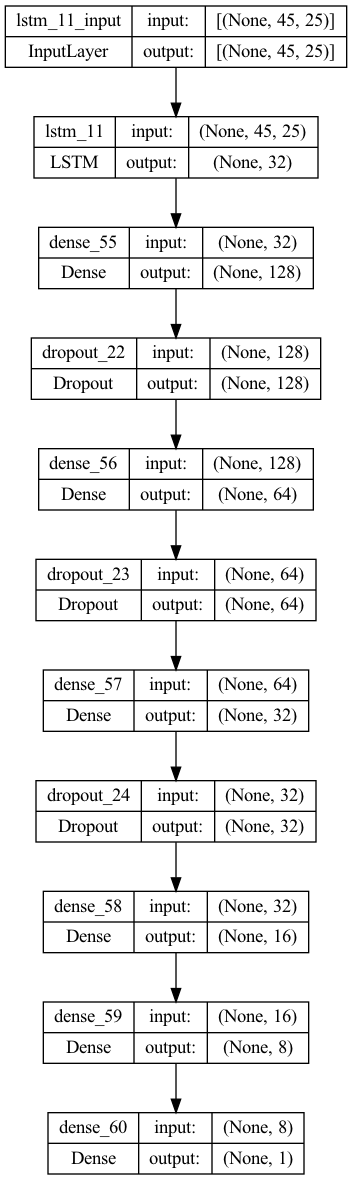

In [43]:
from keras.models import Sequential
from keras.layers import Bidirectional, LSTM, Dense, Conv1D, Dropout, MaxPooling1D, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.metrics import Recall, BinaryAccuracy, AUC, Accuracy
import tensorflow as tf
from keras.utils import plot_model


tf.get_logger().setLevel('INFO')
tf.debugging.set_log_device_placement(False)
metric = "accuracy"

early_stopping = EarlyStopping(monitor=f'val_{metric}', 
                               patience=20, 
                               min_delta=0.0005, 
                               mode='max')

cp_model_checkpoint = ModelCheckpoint("data/tf_models/benchmark/benchmark-{epoch:02d}-{val_accuracy:.4f}.h5",
                                      monitor=f'val_{metric}',
                                      save_best_only=True,
                                      verbose=1,
                                      mode="max")

model = Sequential()
# model.add(Conv1D(name="conv1d_layer1",
#                  filters=32,
#                  kernel_size=(4),
#                  activation="relu"))
# model.add(MaxPooling1D(pool_size=(2)))
# model.add(Flatten(name="flatten",))
model.add(LSTM(32, input_shape=X_Train[0].shape, dropout=0.2,go_backwards=False, return_sequences=False))
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(32, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(16, activation="relu"))
model.add(Dense(8, activation="relu"))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
              optimizer='adam',
              metrics=[metric])
model.build(input_shape=X_Train.shape)
print(model.summary())
plot_model(model, 'autoencoder_compress.png', show_shapes=True)

In [44]:
batch_size = 32
epochs = 100

history = model.fit(X_Train, 
                    Y_Train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(X_Test, Y_Test), 
                    callbacks=[early_stopping, cp_model_checkpoint])#
                    
index = history.history[f'val_{metric}'].index(max(history.history[f'val_{metric}']))
max(history.history[f'val_{metric}'])#, history.history['val_recall'][index]

Epoch 1/100


2022-12-20 18:33:01.582804: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 18:33:02.386283: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 18:33:03.534934: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1766/1766 [==============================] - ETA: 0s - loss: 0.6668 - accuracy: 0.6129

2022-12-20 18:35:16.120499: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 18:35:16.290342: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.61286, saving model to data/tf_models/benchmark/benchmark-01-0.6129.h5
1766/1766 [==============================] - 148s 81ms/step - loss: 0.6668 - accuracy: 0.6129 - val_loss: 0.6657 - val_accuracy: 0.6129
Epoch 2/100
1766/1766 [==============================] - ETA: 0s - loss: 0.6653 - accuracy: 0.6132
Epoch 2: val_accuracy did not improve from 0.61286
1766/1766 [==============================] - 139s 79ms/step - loss: 0.6653 - accuracy: 0.6132 - val_loss: 0.6656 - val_accuracy: 0.6129
Epoch 3/100
1766/1766 [==============================] - ETA: 0s - loss: 0.6647 - accuracy: 0.6132
Epoch 3: val_accuracy did not improve from 0.61286
1766/1766 [==============================] - 172s 97ms/step - loss: 0.6647 - accuracy: 0.6132 - val_loss: 0.6675 - val_accuracy: 0.6129
Epoch 4/100
1766/1766 [==============================] - ETA: 0s - loss: 0.6646 - accuracy: 0.6132
Epoch 4: val_accuracy did not improve from 0.61286
1766/1766 [=============

0.6214902400970459

In [19]:
# Y_test_predict.shape, Y_Test.values.shape
Y_Test.shape, X_Test.shape, Y_test_predict.shape

((10079,), (10079, 45, 27), (453555,))

In [1]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from keras.models import load_model
from data_preparation import PreProcess
import numpy as np

preprocess = PreProcess()
df_test = preprocess.read_dataset_from_parquet("data/train_dataset/indicadores_com_sinais/test_data.parquet")

X_TS_Test = np.array([val[0] for val in df_test.values])
Y_test = df_test.pop('label')
X_SIG_Test = df_test[df_test.columns[~df_test.columns.isin(['series'])]].values

model = load_model("/Users/ricardomonteiro/pythonProjects/projects/proj_final_bimaster/data/tf_models/final_model/model-acc-15-0.6167.h5")

Y_test_predict = (model.predict([X_TS_Test, X_SIG_Test]).flatten() > 0.5).astype(int)

print(f"Accuracy: {accuracy_score(Y_test.values, Y_test_predict):.4f}")
print("Matriz de confusao:\n", confusion_matrix(Y_test.values, Y_test_predict))
print(f"Precision: {precision_score(Y_test.values, Y_test_predict):.4f}")
print(f"Recall: {recall_score(Y_test.values, Y_test_predict):.4f}")
print(f"F1 Score: {f1_score(Y_test.values, Y_test_predict):.4f}")


2023-01-15 09:13:08.221777: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Metal device set to: AMD Radeon Pro 5300M

systemMemory: 16.00 GB
maxCacheSize: 1.99 GB



2023-01-15 09:13:13.179927: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-15 09:13:13.180607: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-15 09:13:13.180659: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-15 09:13:13.180951: I tensorflow/core/common_runtime/pluggable_device/plug

306/306 [==============================] - 15s 42ms/step
Accuracy: 0.6167
Matriz de confusao:
 [[5874   52]
 [3691  149]]
Precision: 0.7413
Recall: 0.0388
F1 Score: 0.0737


In [48]:
df_train = preprocess.read_dataset_from_parquet("data/train_dataset/Sinais-com-historico/train_data.parquet")

df_train.iloc[:1000].groupby('label').count()/1000

,series
label,
0.0,0.642
1.0,0.358
